In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = 'D:/input/flickr30k'
WORKING_DIR = './'

In [3]:
# model = VGG16()
modelr = ResNet50(weights="imagenet", input_shape=(224,224,3))
modelr = Model(inputs=modelr.inputs, outputs=modelr.layers[-2].output)

# print(model.summary())

In [4]:
# features = {}
# directory = os.path.join(BASE_DIR, 'images/flickr30k_images')
# # directory = '../input/flickr30k/images'


# for img_name in tqdm(os.listdir(directory)):
# #     if img_name == 'flickr30k_images':
# #         continue
    
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
# #     image = np.expand_dims(image, axis=0)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = modelr.predict(image)
# #     feature= feature.reshape(feature.shape[1],)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [5]:
# store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'D:/input/feature/features (1).pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r', encoding="utf-8") as f:
    next(f)
    captions_doc = f.read()
    
# print(captions_doc.split('\n')[0])
# captions_doc.split('\n')[1]

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
cnt = 1
for line in tqdm(captions_doc.split('\n')):
#     cnt = cnt+1
        
    tokens = line.split('|')
#     print(tokens)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[2].split(' .')[0]
#     print(tokens[0], ': ', caption)
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
#     caption = " ".join(caption)
#     print(image_id, ': ', caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
#     if cnt==4:
#         break

  0%|          | 0/158916 [00:00<?, ?it/s]

In [9]:
len(mapping)

31783

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
          

mapping['1000092795']
clean(mapping)
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
len(all_captions)

158915

In [12]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

18310

In [15]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [18]:
ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_captions:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    
    
# need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [19]:
f = open("D:/input/glove6b50dtxt/glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

def get_embedding_output():
    
    emb_dim = 256
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()



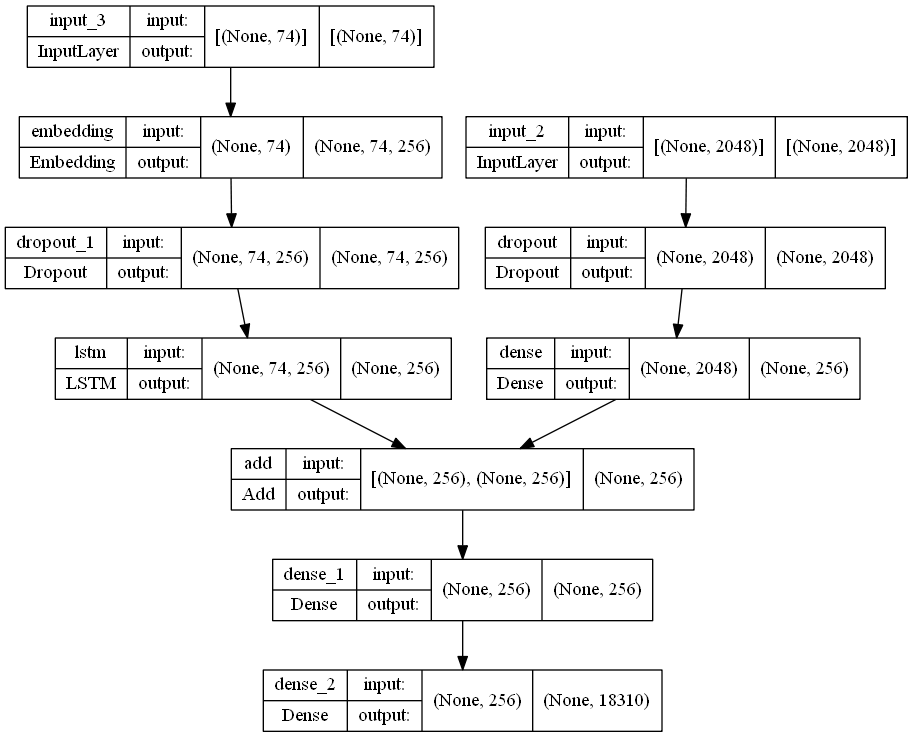

In [20]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [34]:
# train the model
epochs = 26
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  4/893 [..............................] - ETA: 1:30:26 - loss: 9.1766

KeyboardInterrupt: 

In [21]:
# save the model
# model.save(WORKING_DIR+'../input/feature/best_model (1).h5')
model.load_weights("D:/input/feature/best_model (1).h5")
# pickle.dump(model, open('model.pkl', 'wb'))
# with open(os.path.join(WORKING_DIR, '../input/feature/best_model (1).h5'), 'rb') as wb:
#     model = pickle.load(wb)

In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()
cnt = 1
for key in tqdm(test):
    cnt = cnt+1
#     if(cnt==5):
#         break
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/3179 [00:00<?, ?it/s]

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length).split('startseq')[1]
    y_pred = y_pred.split('endseq')[0]
#     print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [25]:
# imagee = '"C:/Users/LENOVO/OneDrive/Desktop/rrr/DD1527EE-4E0F-42FE-87E4-FF49D4BFCDBA.JPG"'
# imag = 

 two young boys are playing with soccer ball 


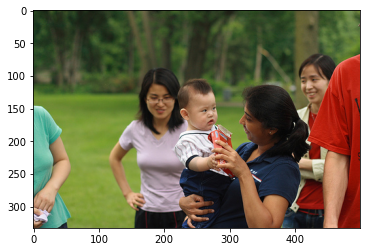

In [25]:
# generate_caption("663237484-img_0568copy_640x480.jpg")
generate_caption("686550300.jpg")
# generate_caption("101669240_b2d3e7f17b.jpg")

In [63]:
from gtts import gTTS
def tts(str):
    audio = gTTS(str)
    audio.save("speech.mp3")

ModuleNotFoundError: No module named 'gtts'

 man is driving blue car in the street 


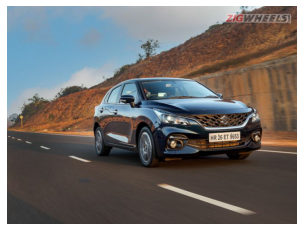

In [28]:
dir = 'D:/input/imgrpr'
image_name = 'D99EBCF7-588A-4CF7-991C-7D8D2649F26C.JPG'
image_id = image_name.split('.')[0]
img_path = os.path.join(dir, image_name)

im = Image.open(img_path)
plt.imshow(im)
plt.axis('off')

image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = modelr.predict(image, verbose=0)
# print(feature)
y_pred = predict_caption(model, feature, tokenizer, max_length).split('startseq')[1]
y_pred = y_pred.split('endseq')[0]
print(y_pred)
#plt.imshow(image)
#tts(y_pred)

 two dogs are running through the grass 


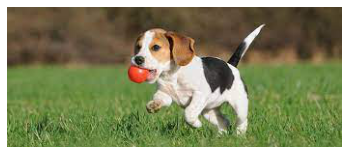

In [26]:
dir = 'D:/input/imgrpr'
image_name = 'dog.jpg'
image_id = image_name.split('.')[0]
img_path = os.path.join(dir, image_name)

im = Image.open(img_path)
plt.imshow(im)
plt.axis('off')

image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = modelr.predict(image, verbose=0)
# print(feature)
y_pred = predict_caption(model, feature, tokenizer, max_length).split('startseq')[1]
y_pred = y_pred.split('endseq')[0]
print(y_pred)
#tts(y_pred)

In [31]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [27]:
from imutils.video import VideoStream
from imutils.video import FPS
import imutils
import time
import cv2
vs = VideoStream(src=0).start()
time.sleep(2.0)
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame1 = vs.read()
    frame1 = imutils.resize(frame1, width=400)
    #image.resize(224,224)
    image = cv2.resize(frame1, (224, 224))
    image = image[...,::-1]
    #image = load_img(frame1, target_size=(224, 224), interpolation='nearest')
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = modelr.predict(image, verbose=0)
    # print(feature)
    y_pred = predict_caption(model, feature, tokenizer, max_length).split('startseq')[1]
    y_pred = y_pred.split('endseq')[0]
    print(y_pred)
    # show the output frame
    cv2.imshow("Frame", frame1)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

 two young girls are laughing and one is wearing red shirt 
 two young boys are laughing and one is puckering up 
 two young boys are laughing and one is puckering up 
 man is shaving his face 
 two young boys are laughing and one is puckering up 
 two young women are laughing and having conversation 
 two young women are laughing and having conversation 
 two young women are laughing and having conversation 
 two young girls are laughing and one is wearing red shirt 
 two young women are laughing and having conversation 
 two young women are laughing and having conversation 
 two young women are laughing and having conversation 
 two young women are laughing and having conversation 
 two young women are sitting in the middle of the room 
 two young women are sitting in the middle of the bed 
 two young women are sitting in the middle of the room 
 two young boys are laughing and one is puckering up 
 two young boys are looking at the camera 
 two young boys are laughing and one is puc

In [41]:
pip install pillow
